In [2]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

load_dotenv()

conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASS"),
    host=os.getenv("DB_HOST", "localhost"),
    port=os.getenv("DB_PORT", "5432")
)

query = """
SELECT * FROM market_orders
WHERE item_name = 'Tritanium'
ORDER BY issued_at DESC
LIMIT 500;
"""

df = pd.read_sql(query, conn)
df.head()


C:\Users\Jouke\AppData\Local\Temp\ipykernel_26740\3237985653.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,id,item_name,price,volume,location,order_type,issued_at
0,351,Tritanium,4.15,241802,60015027,sell,2025-06-24 18:24:51
1,175,Tritanium,4.16,97727677,60003760,sell,2025-06-24 18:14:33
2,350,Tritanium,4.16,97727677,60003760,sell,2025-06-24 18:14:33
3,174,Tritanium,1.01,540001,60010195,sell,2025-06-24 18:14:10
4,349,Tritanium,1.01,540001,60010195,sell,2025-06-24 18:14:10


In [2]:
%pip install requests


  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.6.15-py3-none-any.whl.metadata (2.4 kB)
Using cached requests-2.32.4-py3-none-any.whl (64 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached certifi-2025.6.15-py3-none-any.whl (157 kB)

   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   ---------------- ----------------------- 2/5 [charset_normalizer]
   ---------------- ----------------------- 2/5 [charset_normalizer]
   -------------------------------- ------- 4/5 [requests]
   ---------------------------------------- 5/5 [requests]

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install pandas psycopg2-binary python-dotenv matplotlib requests


Note: you may need to restart the kernel to use updated packages.


C:\Users\Jouke\AppData\Local\Temp\ipykernel_26740\2731029150.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Jouke\Documents\evedata-logger\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


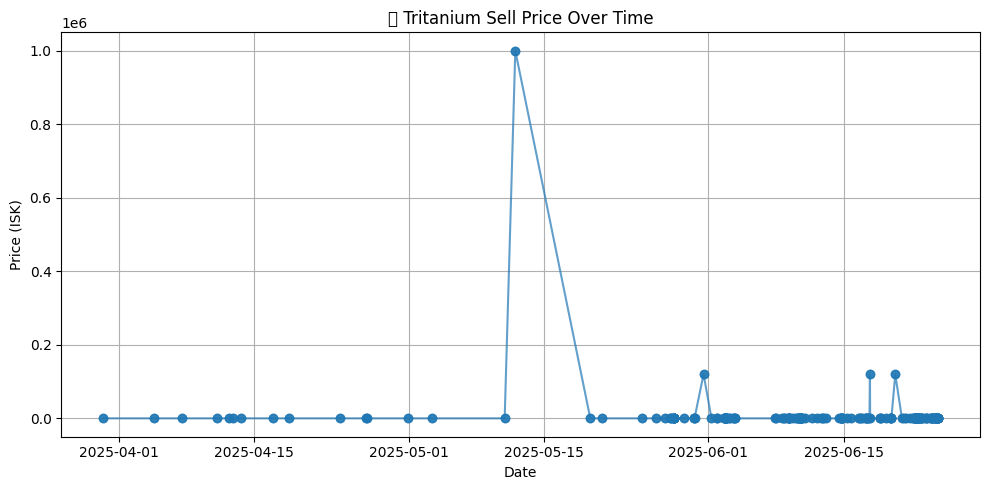

In [3]:
import matplotlib.pyplot as plt

# Convert issued_at to datetime
df['issued_at'] = pd.to_datetime(df['issued_at'])

# Sort by time (older → newer)
df = df.sort_values('issued_at')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['issued_at'], df['price'], marker='o', linestyle='-', alpha=0.7)
plt.title('📈 Tritanium Sell Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (ISK)')
plt.grid(True)
plt.tight_layout()
plt.show()
